###### IMPORTANDO AS FUNÇÕES

In [61]:
import yaml  
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

###### DEFININDO AS FUNÇÕES DO PROJETO

In [34]:
plt.rcParams["figure.figsize"] = (18,5)
plt.rcParams["figure.figsize"] = (18,5)

def load_yaml(file_path):
    """
    Carrega um arquivo YAML e retorna os dados como um dicionário.
    """
    with open(file_path, "r") as file:
        return yaml.safe_load(file)

def csv_to_dataframe(csv_file):
    """
    Lê o arquivo CSV e o converte em um DataFrame
    """
    df = pd.read_csv(csv_file, sep = ';')
    return df    
    
def variaveis_type(file_path):
    """Classifica variáveis em listas com base no metadado presente no arquivo YAML de settings
    
    Parâmetros: file_path(str): Caminho para o arquivo yaml
    
    Retorna: dict: Um dicionario com listas de variáveis classificadas por tipo
    """
    data = load_yaml(file_path)
    var_qual_nomi = []
    var_quant_cont = []
    var_quant_discr = []
    
    for coluna, details in data['csv']['table']['columns'].items():
        if details['metadado'] == 'qualitativo nominal':
            var_qual_nomi.append(coluna)
        elif details['metadado'] == 'quantitativo continuo':
            var_quant_cont.append(coluna)
        else:
            var_quant_discr.append(coluna)
    return { "Qualitativo nominal": var_qual_nomi,
             "Quantitativo continua":var_quant_cont,
             "Quantitativo discreta":var_quant_discr}


        
def grafico_quantitativo_continuo(df, target, vars_numericas, output_dir=None):
    """
    Gera gráficos de densidade (KDE) para variáveis quantitativas contínuas em relação ao target.
    
    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        target (str): Nome da variável target.
        vars_numericas (list): Lista de nomes das variáveis quantitativas contínuas.
        output_dir (str, opcional): Diretório onde os gráficos serão salvos. 
                                    Se None, os gráficos não serão salvos.
    """
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
  
    grupo_nao = df[df[target] == 0].filter(vars_numericas)
    grupo_sim = df[df[target] == 1].filter(vars_numericas)
    
   
    for var in vars_numericas:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(grupo_nao[var].dropna(), bw_adjust=0.5, label="Não", fill=True)
        sns.kdeplot(grupo_sim[var].dropna(), bw_adjust=0.5, label="Sim", fill=True)
        plt.xlabel(var, fontsize=12)
        plt.ylabel("Densidade", fontsize=12)
        plt.title(f"{var} em relação ao {target}", fontsize=14)
        plt.legend(title=target, fontsize=10)
        plt.tight_layout()
        if output_dir:
            file_path = os.path.join(output_dir, f"{var}_grafico.png")
            plt.savefig(file_path, format="png")
            print(f"Gráfico salvo em: {file_path}")
        
        plt.show()
        plt.close()


# Função para gráficos de variáveis quantitativas discretas
def grafico_quantitativo_discreto(df, variaveis, target):
    """
    Gera gráficos de barras ordenados para variáveis qualitativas ordinais.
    
    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        variaveis (list): Lista de nomes das variáveis qualitativas ordinais.
        target (str): Nome da variável target.
    """
    for var in variaveis:
        sns.histplot(x=var, hue=target, data=df, stat="count", multiple="stack")
        plt.show()

In [35]:
path_yaml = 'database.yaml'

In [36]:
config = load_yaml(path_yaml)

In [37]:
path_images = config['csv']['path_images']

In [38]:
path = config['csv']['path']

In [39]:
df = csv_to_dataframe(path)

In [40]:
display(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [41]:
le = LabelEncoder()

In [42]:
ignore = ['customerID','MonthlyCharges','TotalCharges']
no_ignore = [ col for col in df if col not in ignore]

for col in no_ignore:
    df[col] = le.fit_transform(df[col])
    print(f"realizando a transformação para a coluna {col}")

realizando a transformação para a coluna gender
realizando a transformação para a coluna SeniorCitizen
realizando a transformação para a coluna Partner
realizando a transformação para a coluna Dependents
realizando a transformação para a coluna tenure
realizando a transformação para a coluna PhoneService
realizando a transformação para a coluna MultipleLines
realizando a transformação para a coluna InternetService
realizando a transformação para a coluna OnlineSecurity
realizando a transformação para a coluna OnlineBackup
realizando a transformação para a coluna DeviceProtection
realizando a transformação para a coluna TechSupport
realizando a transformação para a coluna StreamingTV
realizando a transformação para a coluna StreamingMovies
realizando a transformação para a coluna Contract
realizando a transformação para a coluna PaperlessBilling
realizando a transformação para a coluna PaymentMethod
realizando a transformação para a coluna Churn


In [43]:
df.to_csv("labelencoder.csv", index = False)

In [44]:
#conecta no yaml e retorna um dicionario com as variaveis
type_var = variaveis_type(path_yaml)
for chave, valor in type_var.items():
    print(f"{chave} -> contém as seguintes variaveis: {valor}\n")

Qualitativo nominal -> contém as seguintes variaveis: ['customerID']

Quantitativo continua -> contém as seguintes variaveis: ['MonthlyCharges', 'TotalCharges']

Quantitativo discreta -> contém as seguintes variaveis: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']



In [45]:
vars_numericas = df.select_dtypes(include=['number']).columns.tolist()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

### Analise descritiva das variaveis

###### Analise das variaveis discretas em relação a target

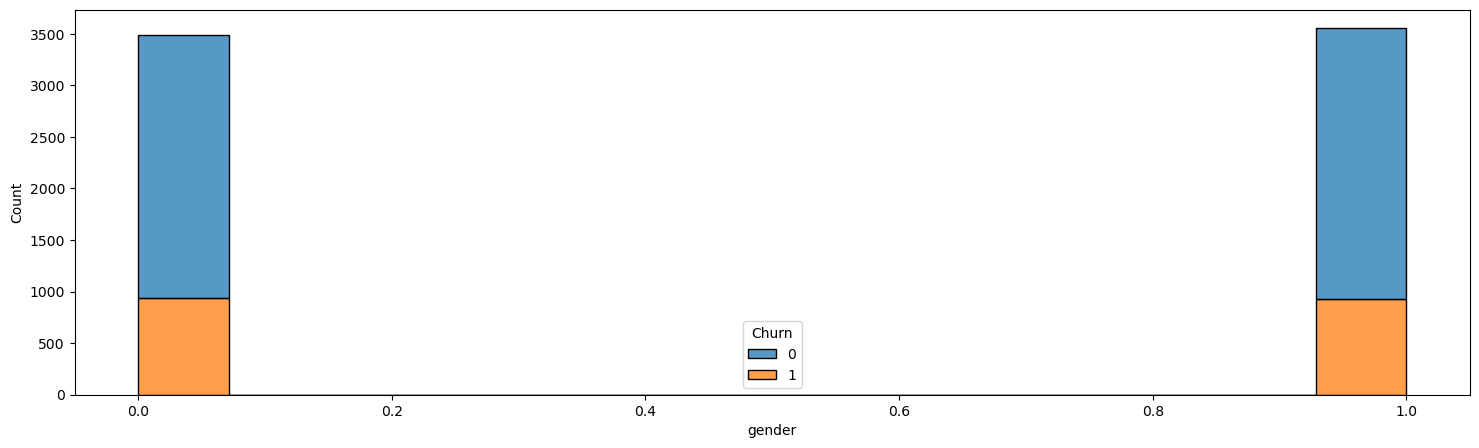

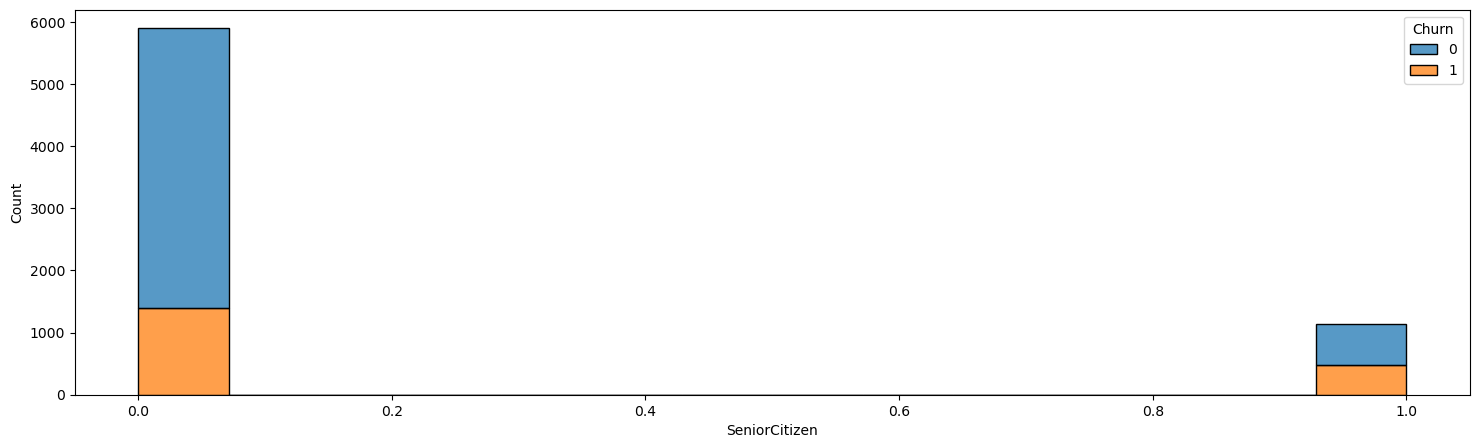

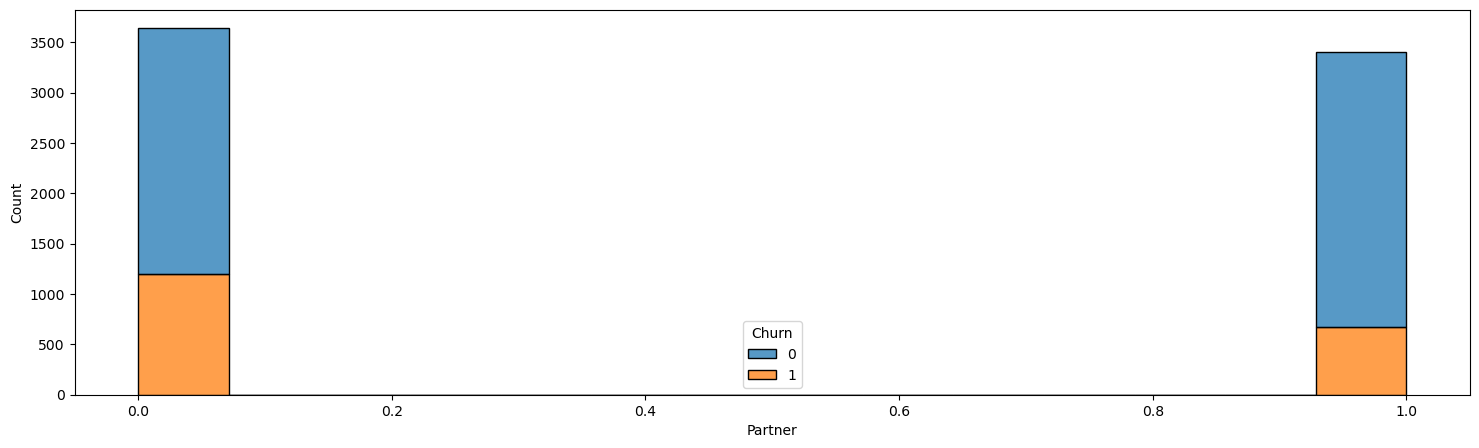

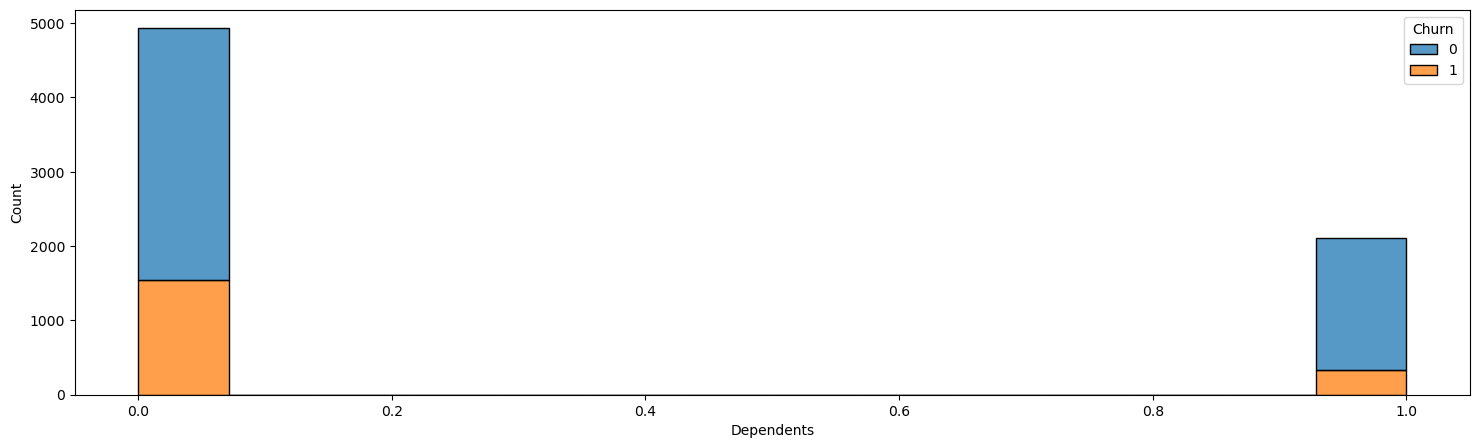

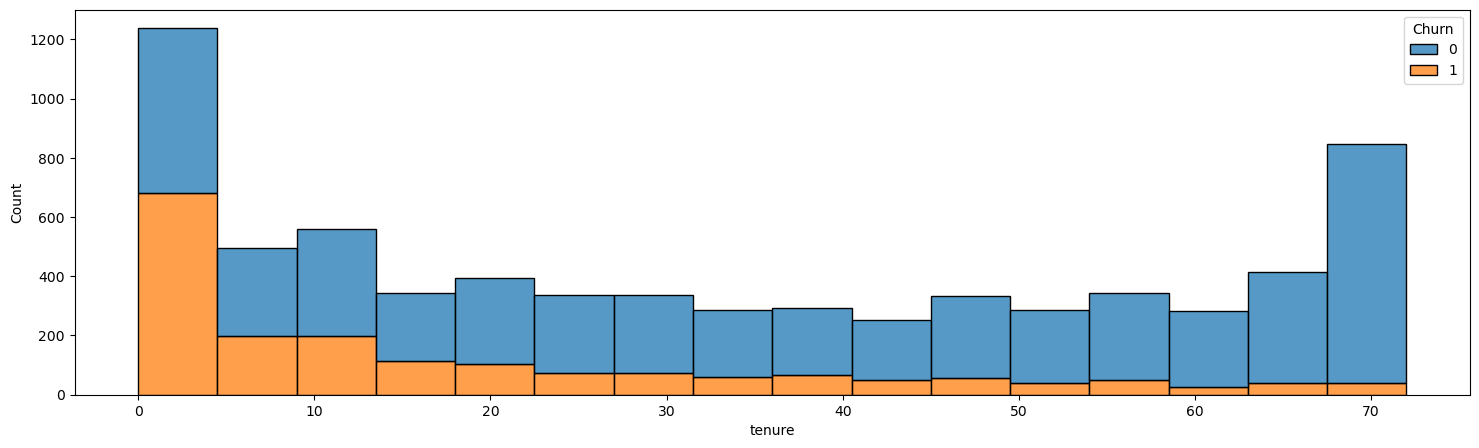

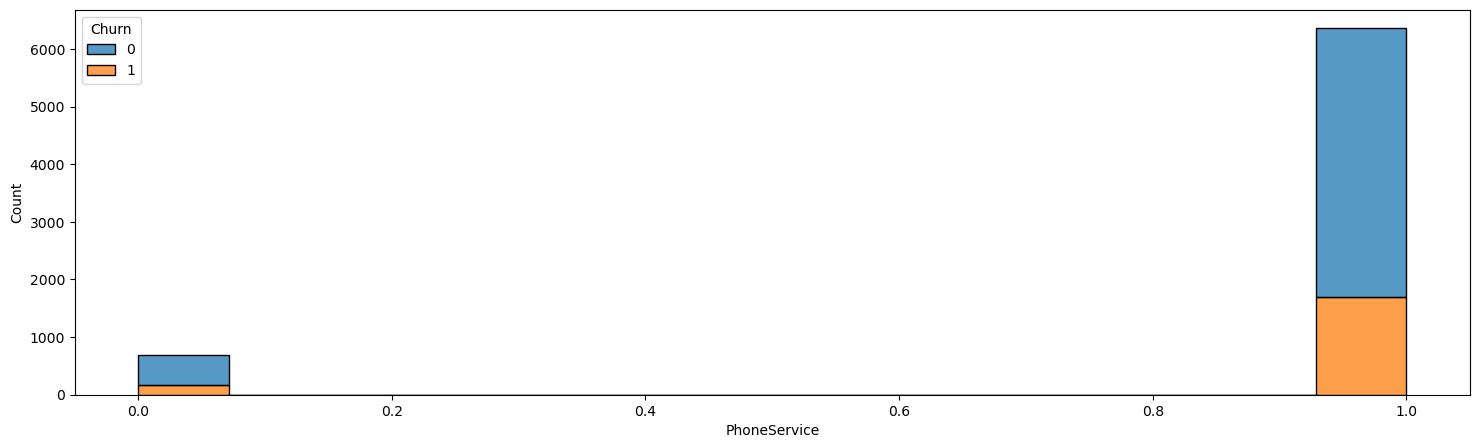

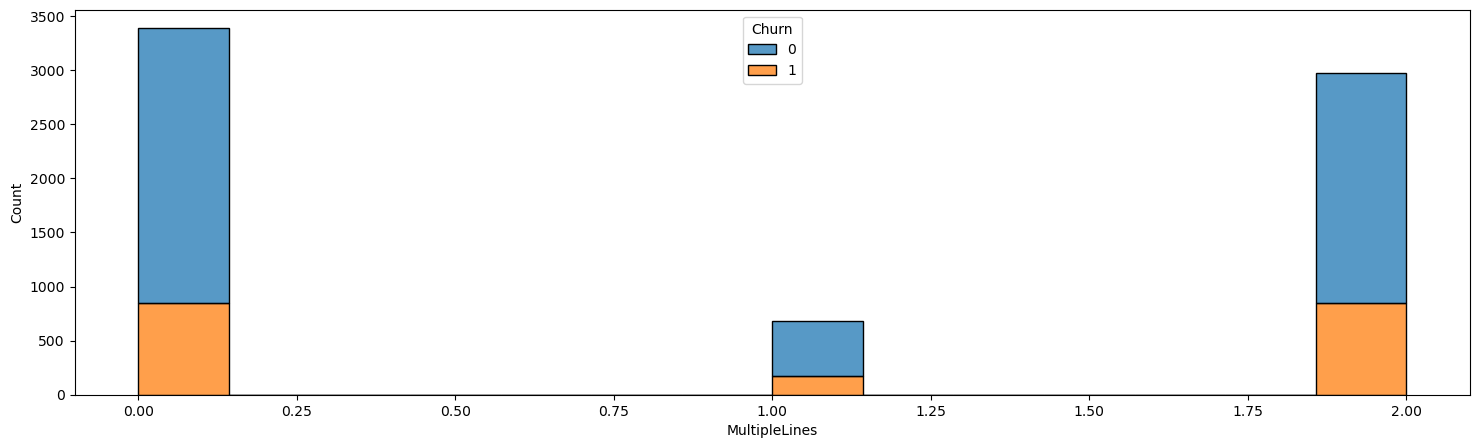

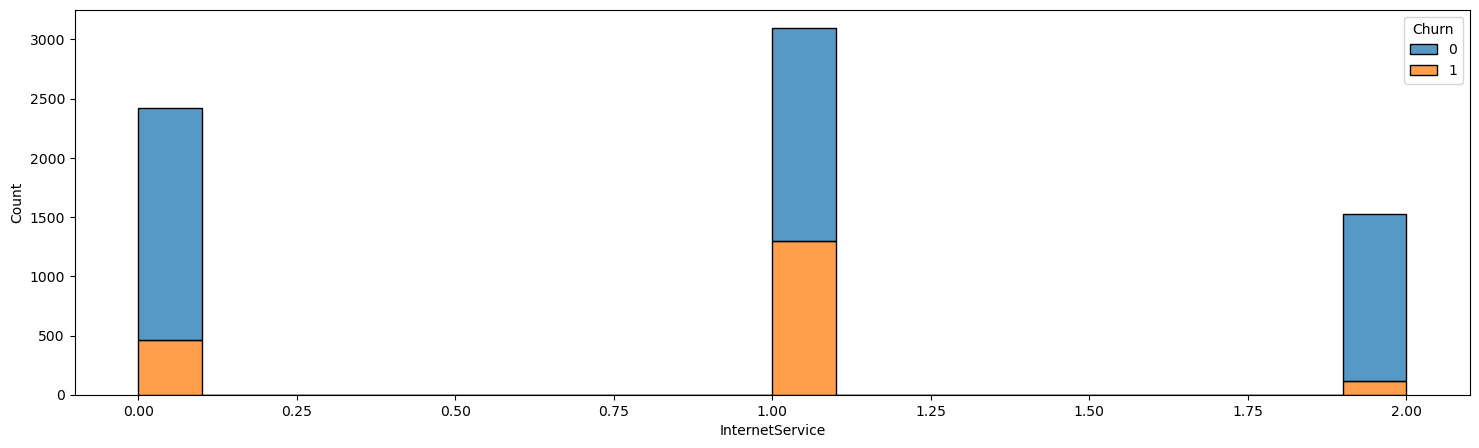

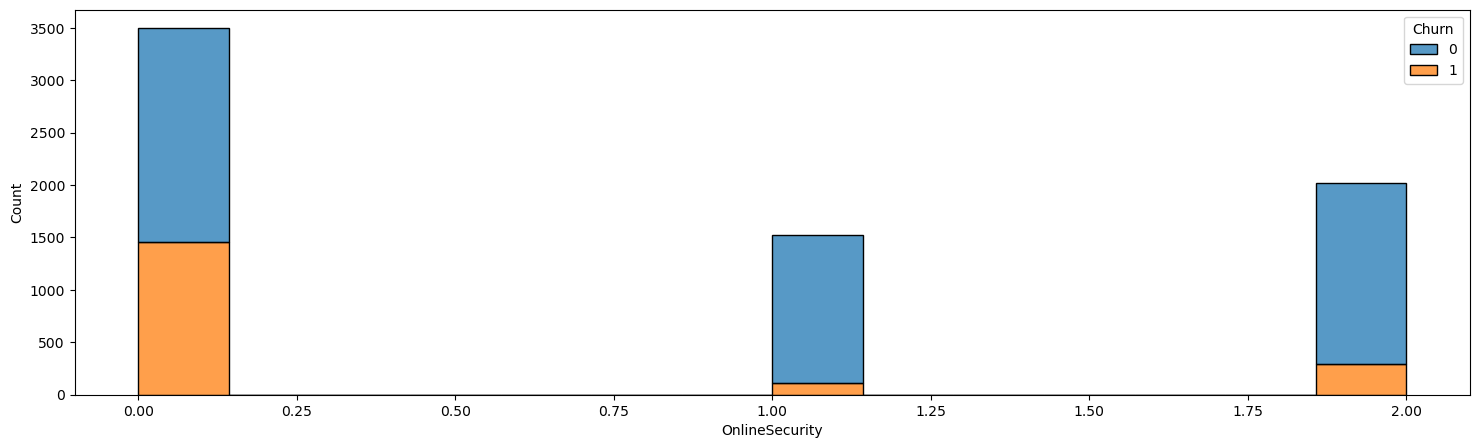

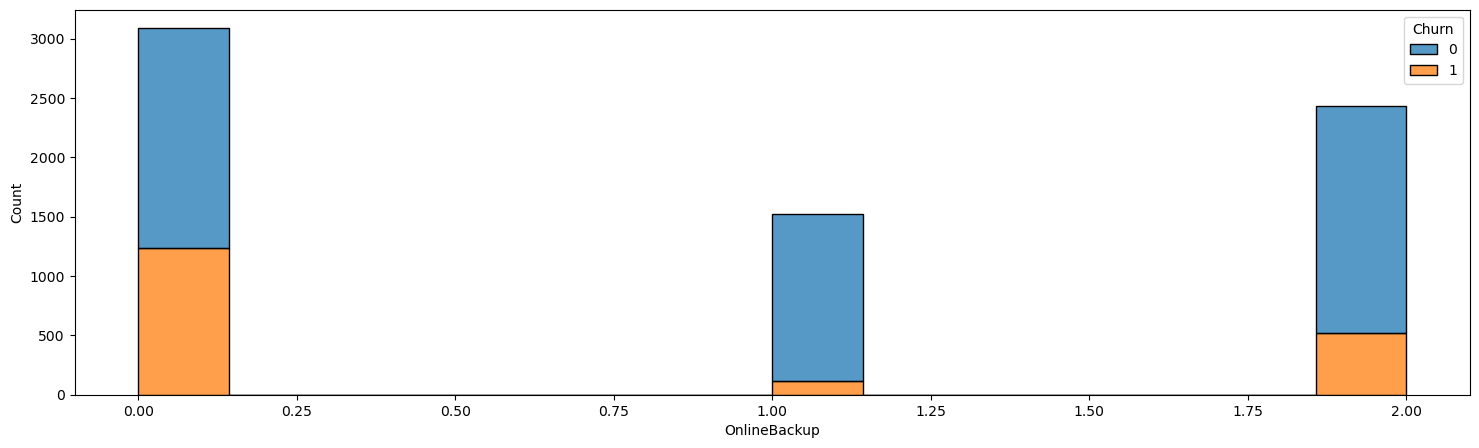

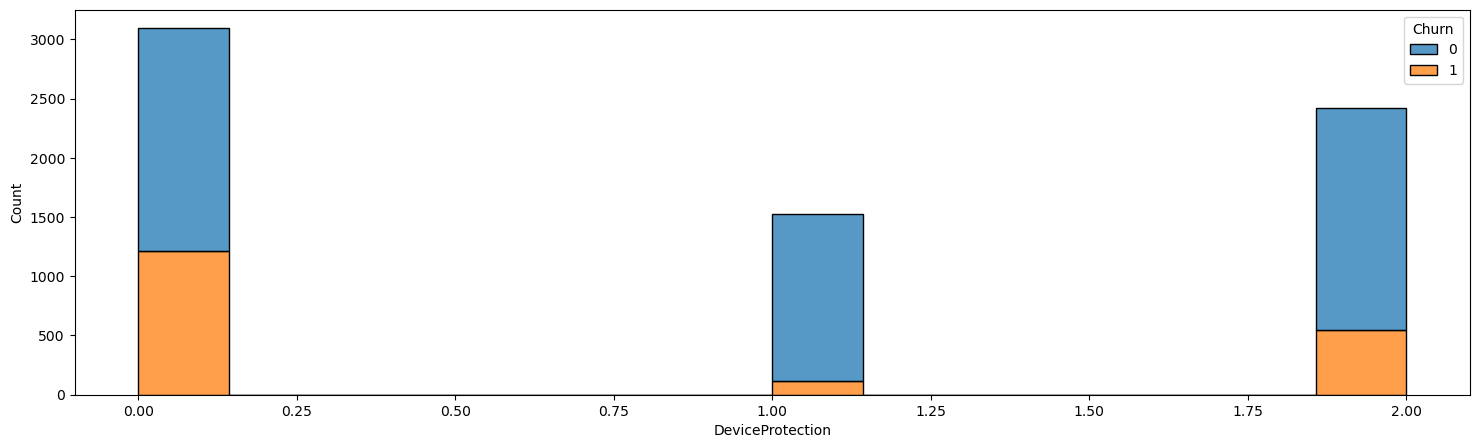

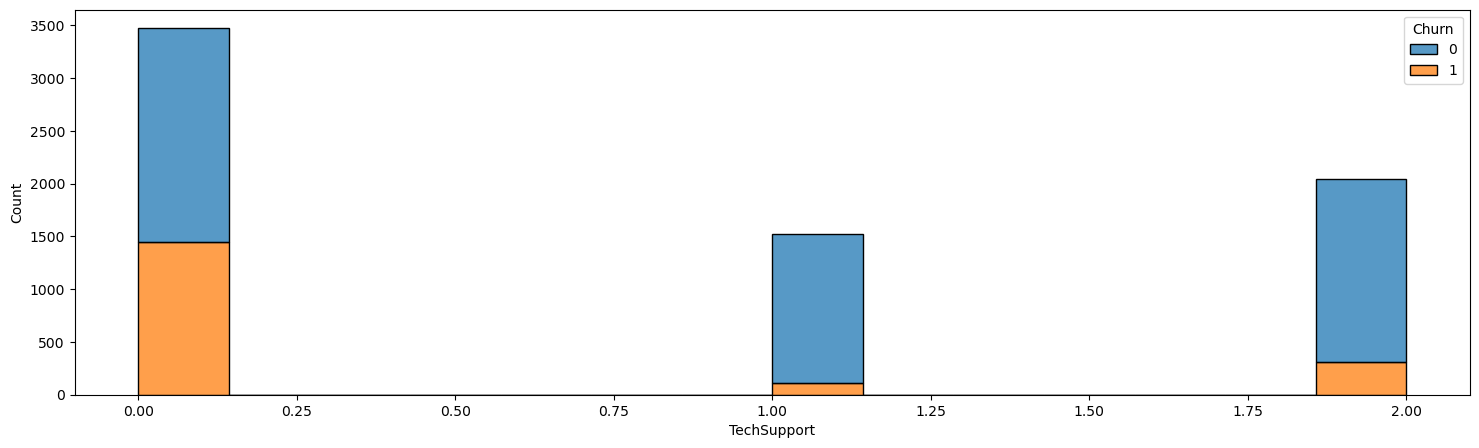

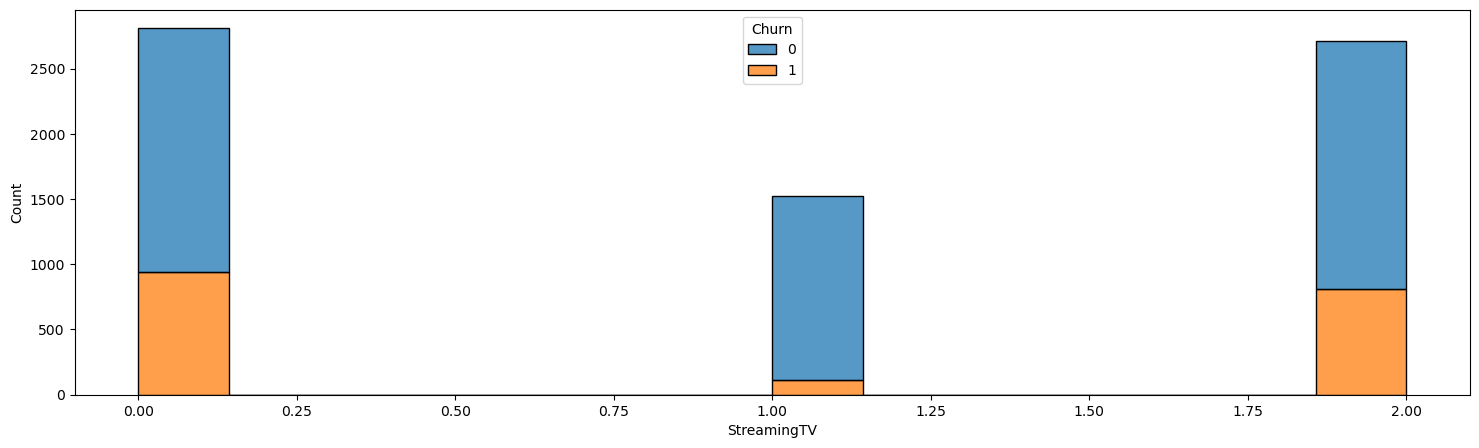

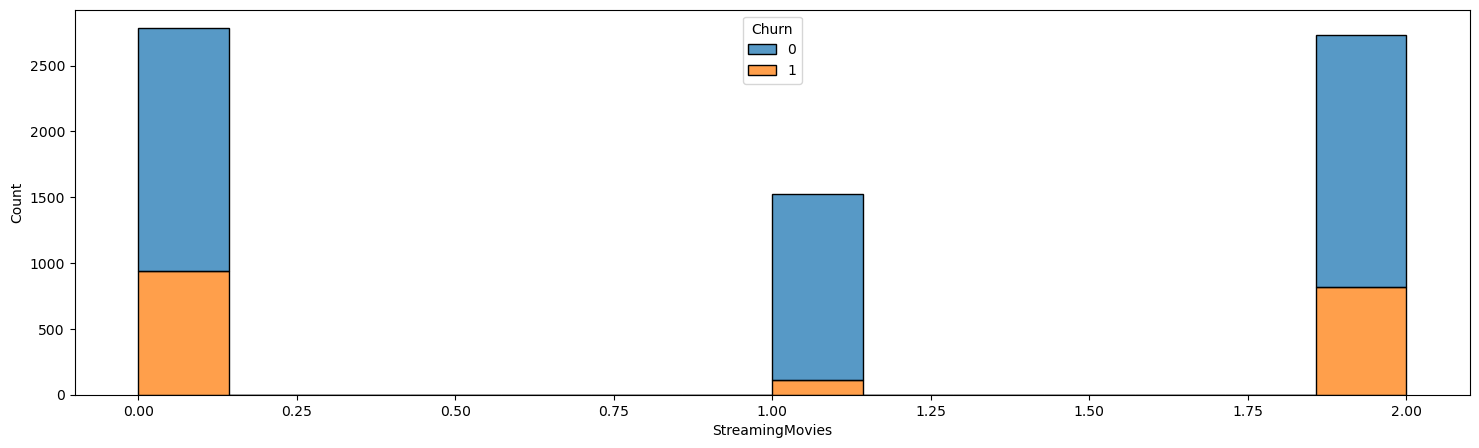

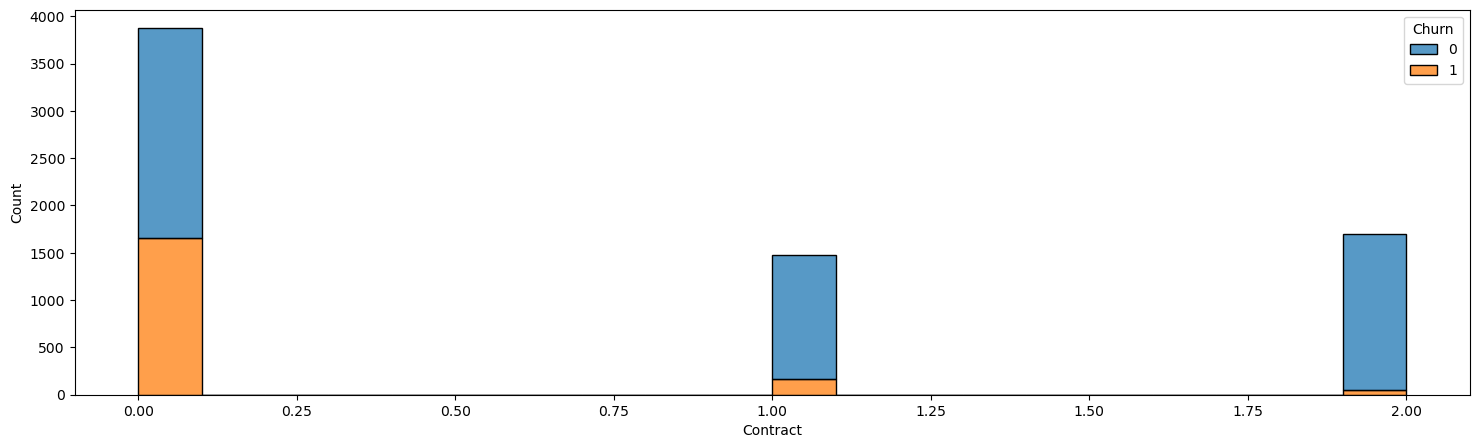

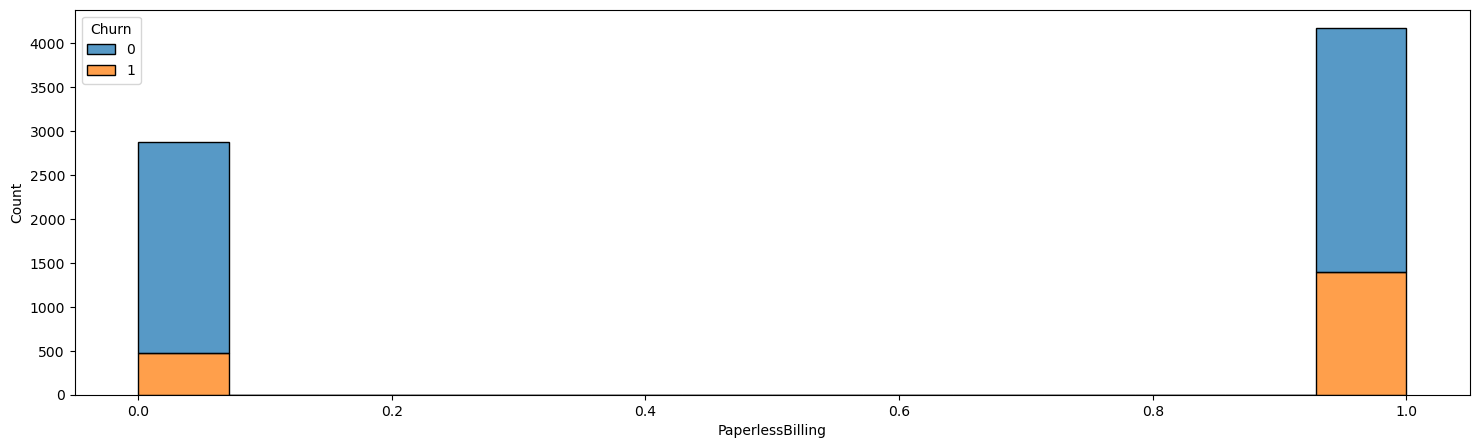

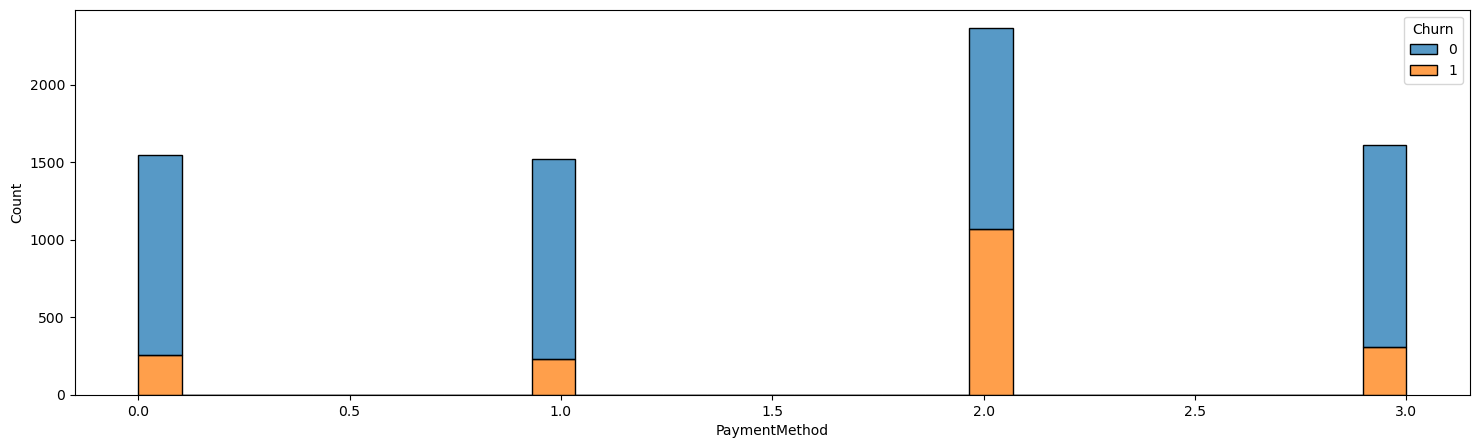

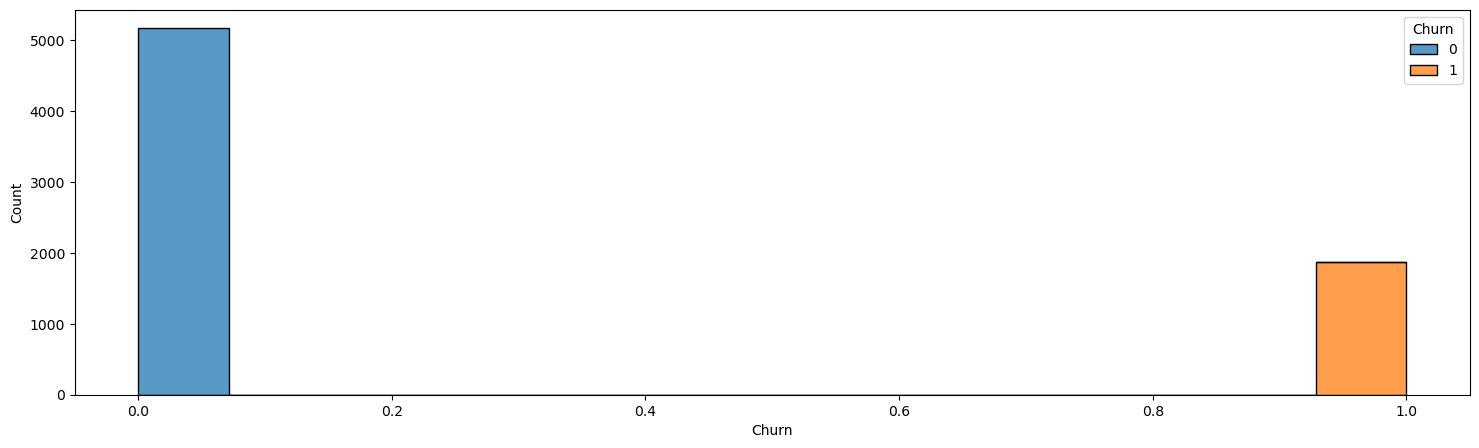

In [46]:
grafico_quantitativo_discreto(df,type_var['Quantitativo discreta'],'Churn')

##### analise descritiva das variaveis continuas em relação a target

Gráfico salvo em: C:\Users\1\Desktop\vivo\images\MonthlyCharges_grafico.png


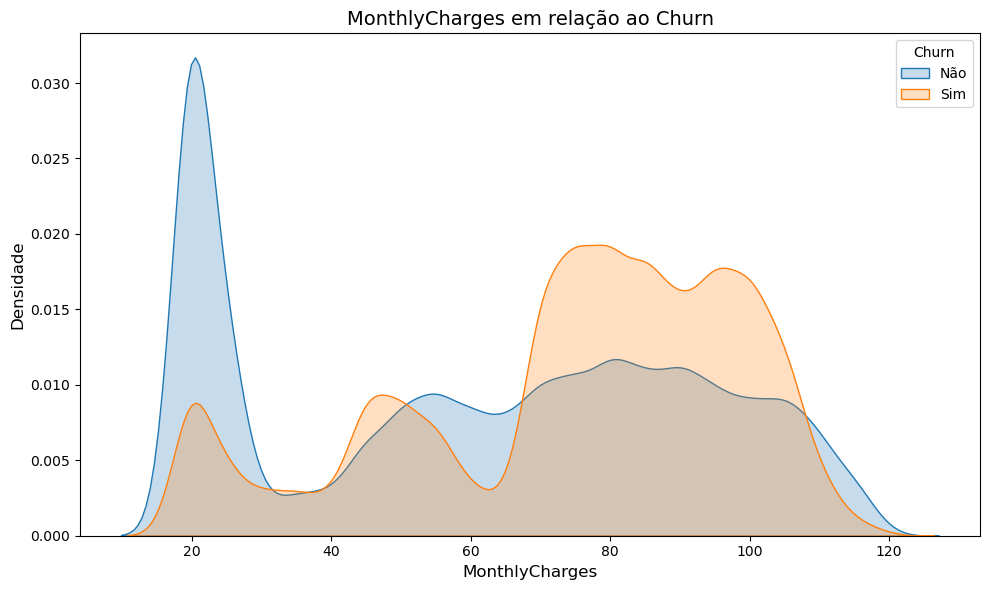

Gráfico salvo em: C:\Users\1\Desktop\vivo\images\TotalCharges_grafico.png


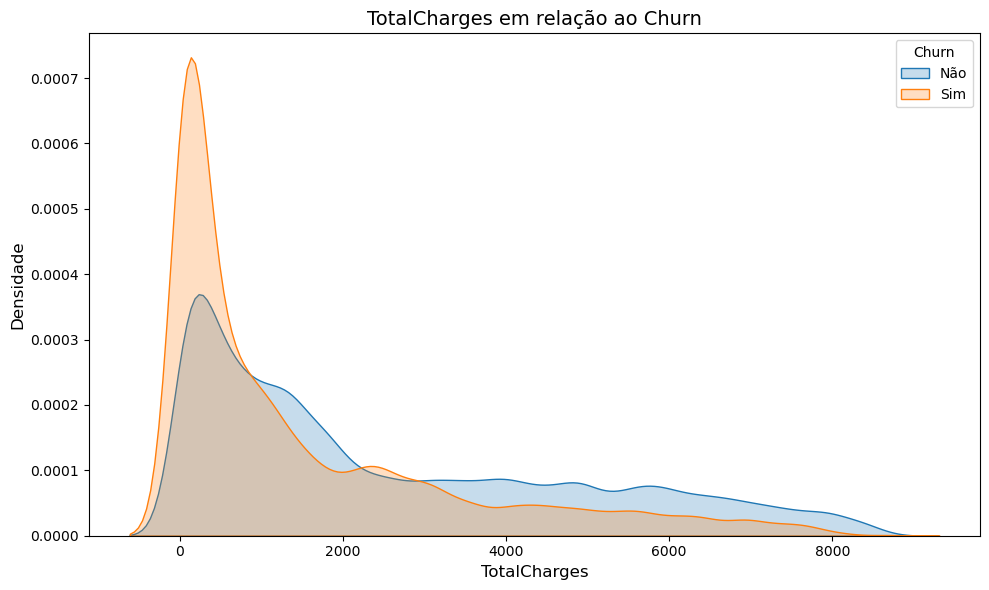

In [47]:
grafico_quantitativo_continuo(df,target="Churn",vars_numericas=type_var["Quantitativo continua"], output_dir = path_images)

In [48]:
#tratando as colunas para o dataframe de teste para que o ligthGBM possa rodar
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category')
    else:
        print(f'coluna {column} já esta no formato correto')
print('Colunas alteradas no dataframe de teste')

coluna gender já esta no formato correto
coluna SeniorCitizen já esta no formato correto
coluna Partner já esta no formato correto
coluna Dependents já esta no formato correto
coluna tenure já esta no formato correto
coluna PhoneService já esta no formato correto
coluna MultipleLines já esta no formato correto
coluna InternetService já esta no formato correto
coluna OnlineSecurity já esta no formato correto
coluna OnlineBackup já esta no formato correto
coluna DeviceProtection já esta no formato correto
coluna TechSupport já esta no formato correto
coluna StreamingTV já esta no formato correto
coluna StreamingMovies já esta no formato correto
coluna Contract já esta no formato correto
coluna PaperlessBilling já esta no formato correto
coluna PaymentMethod já esta no formato correto
coluna MonthlyCharges já esta no formato correto
coluna TotalCharges já esta no formato correto
coluna Churn já esta no formato correto
Colunas alteradas no dataframe de teste


In [49]:
display(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,2,0,2,...,2,2,2,2,1,1,3,84.80,1990.50,0
7039,2234-XADUH,0,0,1,1,72,1,2,1,0,...,2,0,2,2,1,1,1,103.20,7362.90,0
7040,4801-JZAZL,0,0,1,1,11,0,1,0,2,...,0,0,0,0,0,1,2,29.60,346.45,0
7041,8361-LTMKD,1,1,1,0,4,1,2,1,0,...,0,0,0,0,0,1,3,74.40,306.60,1


In [50]:
X = df.drop(columns=['Churn'])
y = df['Churn']

categorical_columns = X.select_dtypes(include=['category', 'object']).columns

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=[X_train.columns.get_loc(col) for col in categorical_columns])
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=[X_val.columns.get_loc(col) for col in categorical_columns])

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": -1,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "verbose": -1
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=["train", "valid"]  
)

y_pred = model.predict(X_val, num_iteration=model.best_iteration)

model.save_model("lightgbm_model.txt")

importance = pd.DataFrame({
    "Feature": model.feature_name(),
    "Importance": model.feature_importance()
}).sort_values(by="Importance", ascending=False)

print(importance)

importance.to_csv("feature_importance.csv", index=False)

             Feature  Importance
18    MonthlyCharges        8266
19      TotalCharges        7673
5             tenure        4503
17     PaymentMethod        1371
1             gender        1018
16  PaperlessBilling         784
7      MultipleLines         685
3            Partner         681
15          Contract         609
10      OnlineBackup         600
11  DeviceProtection         555
12       TechSupport         521
4         Dependents         510
9     OnlineSecurity         508
14   StreamingMovies         480
2      SeniorCitizen         469
13       StreamingTV         431
8    InternetService         234
6       PhoneService         102
0         customerID           0


In [51]:
y_pred_val = model.predict(X_val)
auc_score_val = roc_auc_score(y_val, y_pred_val)
print(f"AUC no conjunto de validação: {auc_score_val*100}%")

AUC no conjunto de validação: 83.05661080460008%


In [52]:
X_val = X.loc[X_val.index] 
df_result = pd.DataFrame({
    'CustomerID': X_val['customerID'], 
    'predictedValues': y_pred          
})


df_result.to_csv("Resultado.csv", encoding='utf-8', float_format='%.8f')
df_result.sort_values(by='predictedValues', ascending=False).to_csv("Resultado_sorted.csv", encoding='utf-8', float_format='%.8f')

In [53]:
display(df_result)

,CustomerID,predictedValues
185,1024-GUALD,0.853097
2715,0484-JPBRU,0.038201
3825,3620-EHIMZ,0.000909
1807,6910-HADCM,0.873597
132,8587-XYZSF,0.000713
...,...,...
6366,2845-KDHVX,0.000429
315,5027-YOCXN,0.143606
2439,8884-MRNSU,0.030140
5002,0567-XRHCU,0.000257


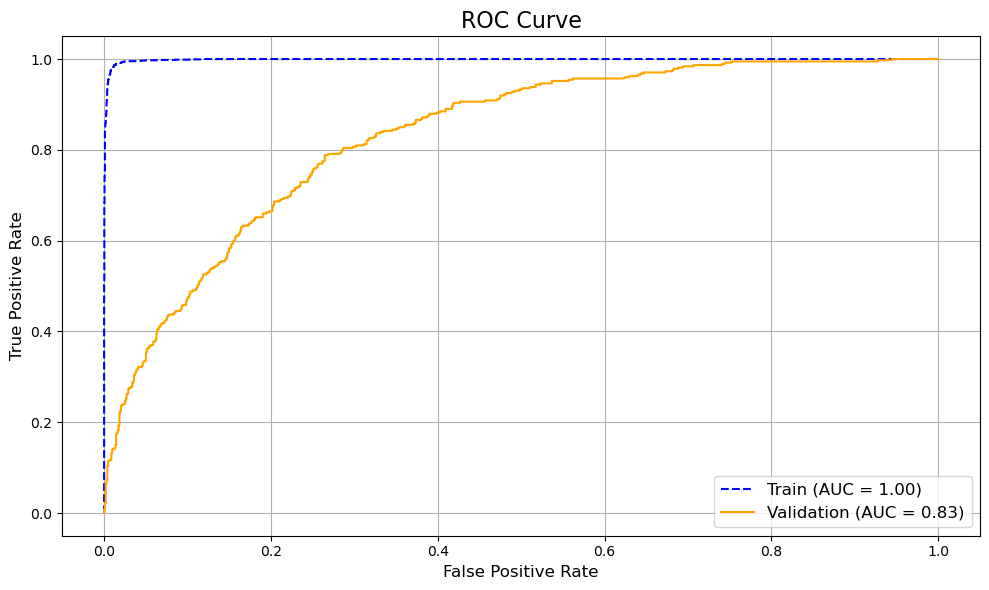

In [54]:
fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train))
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_val)
auc_train = auc(fpr_train, tpr_train)
auc_val = auc(fpr_val, tpr_val)
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.2f})', linestyle='--', color='blue')
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.2f})', linestyle='-', color='orange')
plt.title('ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png')  
plt.show()

##### RandomForest

In [55]:
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [56]:
df = df.dropna()  

In [57]:

X = df.drop(columns=['Churn', 'customerID']) 
y = df['Churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None,    
    random_state=42,   
    n_jobs=-1         
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
y_proba = rf_model.predict_proba(X_val)[:, 1] 


In [58]:
acc = accuracy_score(y_val, y_pred)
print(f"Acurácia: {acc:.4f}")
auc = roc_auc_score(y_val, y_proba)
print(f"AUC-ROC: {auc:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_val, y_pred))

Acurácia: 0.7925
AUC-ROC: 0.8134

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [59]:
auc = roc_auc_score(y_val, y_proba)
print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.8134


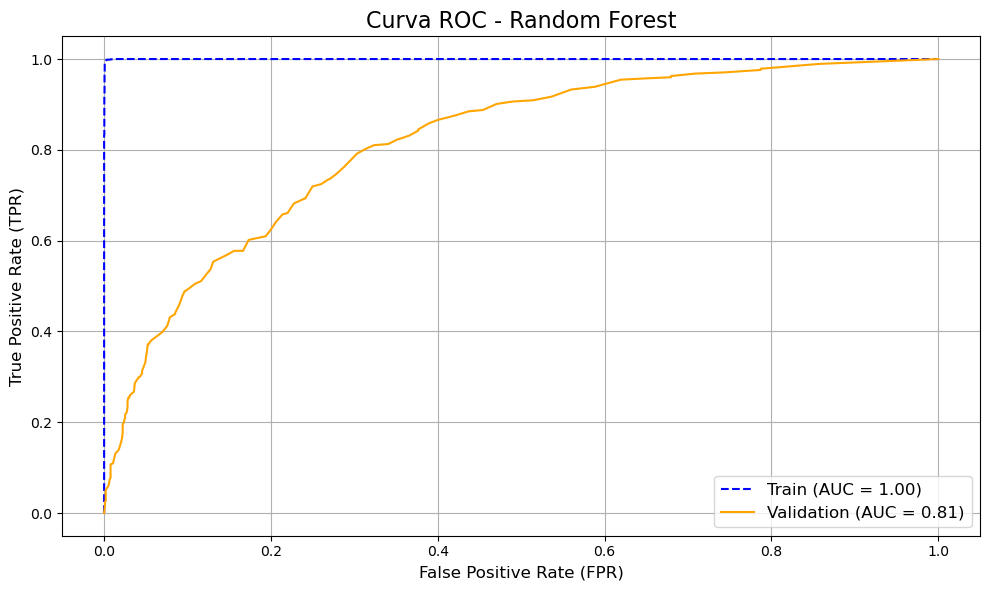

In [62]:
y_proba_train = rf_model.predict_proba(X_train)[:, 1]   
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
auc_train = auc(fpr_train, tpr_train)

y_proba_val = rf_model.predict_proba(X_val)[:, 1]  
fpr_val, tpr_val, _ = roc_curve(y_val, y_proba_val)
auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.2f})', linestyle='--', color='blue')
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.2f})', linestyle='-', color='orange')
plt.title('Curva ROC - Random Forest', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.savefig('roc_curve_random_forest.png')  
plt.show()
